In [1]:
import matplotlib.pyplot as plt
import cupy as cp
from tqdm import tqdm

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
num_classes = 10

#
# make a matrix each column of which represents an images in a vector form 
#
images  = cp.empty((num_image, size_row * size_col), dtype=float)
labels  = cp.empty(num_image, dtype=int)

for cnt, line in enumerate(data):

    line_data   = line.split(',')
    label       = int(line_data[0])
    im_vector   = cp.array(list(map(int, line_data[1:])))

    labels[cnt]    = label
    images[cnt]    = im_vector

# one-hot
labels = cp.eye(num_classes)[labels]
images = images / 255
    
# Split Data
train_images = images[:6000]
train_labels = labels[:6000]
test_images = images[6000:]
test_labels = labels[6000:]

print(train_images.shape)
print(test_images.shape)


(6000, 784)
(4000, 784)


In [2]:
# Define module

def sigmoid(x):
    return 1 / (1 + cp.exp(-x))

class Model:
    def __init__(self, in_shapes, out_shapes):
        std = 1
        self.weight_1 = cp.random.normal(0, std, (196, in_shapes))
        self.weight_2 = cp.random.normal(0, std, (49, 196))
        self.weight_3 = cp.random.normal(0, std, (out_shapes, 49))
        
        self.bias_1 = cp.random.normal(0, std, (196, 1))
        self.bias_2 = cp.random.normal(0, std, (49, 1))
        self.bias_3 = cp.random.normal(0, std, (out_shapes, 1))
        
        self.node_1 = 0
        self.node_2 = 0
        self.node_3 = 0
        self.node_4 = 0
    
    def __call__(self, x):
        x = x.T
        batch = x.shape[-1]
        
        self.node_1 = x
        x = sigmoid(self.weight_1 @ x + self.bias_1)
        
        self.node_2 = x
        x = sigmoid(self.weight_2 @ x + self.bias_2)
        
        
        self.node_3 = x
        x = sigmoid(self.weight_3 @ x + self.bias_3)
        
        self.node_4 = x
        return x.T
    
    def backprop(self, preds, labels, lr):
        batch_size = preds.shape[0]
        preds, label = preds.T, labels.T
        
        error_4 = preds - label
        error_3 = self.weight_3.T @ error_4 * (self.node_3 * (1 - self.node_3))
        error_2 = self.weight_2.T @ error_3 * (self.node_2 * (1 - self.node_2))
        
        self.weight_3 -= lr * error_4 @ self.node_3.T / batch_size
        self.weight_2 -= lr * error_3 @ self.node_2.T / batch_size
        self.weight_1 -= lr * error_2 @ self.node_1.T / batch_size
        
        self.bias_3 -= lr * error_4.sum(axis=1, keepdims=True) / batch_size
        self.bias_2 -= lr * error_3.sum(axis=1, keepdims=True) / batch_size
        self.bias_1 -= lr * error_2.sum(axis=1, keepdims=True) / batch_size
        

        
class BinaryCrossEntropy:
    labels = 0
    preds = 0
    def __call__(self, preds, labels):
        self.labels = labels
        self.preds = preds
        
        return -(labels * cp.log(preds) + (1 - labels) * cp.log(1 - preds)).mean()
    
class LearningRateScheduler:
    def __init__(self, init_lr, final_step, warm_up_step = 0):
        self.init_lr = init_lr
        self.final_step = final_step
        self.warm_up_step = warm_up_step
        self.lr = 0
        self._step = 0
    
    def step(self):
        self._step += 1
        # Learning rate Warm-up
        if (step < self.warm_up_step):
            self.lr = (self.init_lr / self.warm_up_step) * self._step
        # Cos scheduler
        else:
            self.lr = (cp.cos(cp.pi * ((self._step - self.warm_up_step) / (self.final_step - self.warm_up_step))) + 1) / 2 * self.init_lr
        
    def get_lr(self):
        return self.lr

In [3]:
# define computation
def compute_acc(preds, labels):
    pred_nums = cp.argmax(preds, axis=1)
    lable_nums = cp.argmax(labels, axis=1)
    num_correct = (pred_nums == lable_nums).sum()
    return (pred_nums == lable_nums).sum() / preds.shape[0]

In [4]:
# defclare hyterparamter
epoch = 4000
warm_up_epoch = epoch // 10
initial_lr = 10

model = Model(784, 10)

criterion = BinaryCrossEntropy()
lr = LearningRateScheduler(initial_lr, epoch, warm_up_epoch)

In [5]:
train_accuracyes = []
test_accuracyes = []
train_losses = []
test_losses = []
lrs = []

for step in tqdm(range(epoch)):
    # predict test label
    test_preds = model(test_images)
    test_loss = criterion(test_preds, test_labels)
    test_acc = compute_acc(test_preds, test_labels)
    
    # predict train label
    train_preds = model(train_images)
    train_loss = criterion(train_preds, train_labels)
    train_acc = compute_acc(train_preds, train_labels)
    
    # backporpagation
    model.backprop(train_preds, train_labels, lr.lr)
    
    # save results
    train_accuracyes += [train_acc]
    test_accuracyes += [test_acc]
    
    train_losses += [train_loss]
    test_losses += [test_loss]
    lrs += [lr.lr]
    
    lr.step()

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:57<00:00, 34.08it/s]


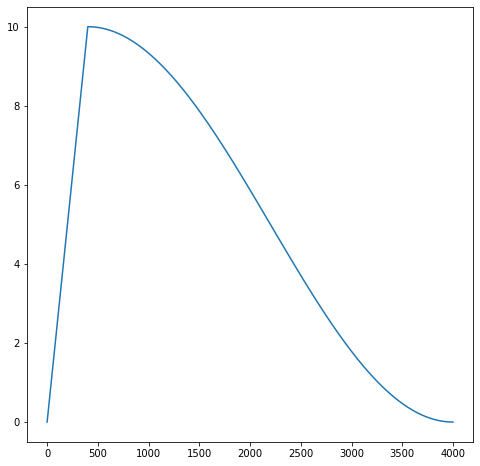

In [6]:
plt.figure(figsize=(8, 8))
plt.plot(lrs)
plt.show()

I use learning rate warm-up and cos scheduler for stable training

In [7]:
# Split correct answer and worng answer

is_correct = cp.argmax(test_preds, axis=1) == cp.argmax(test_labels, axis=1)

correct_images = test_images[is_correct]
correct_labels = test_preds[is_correct]

worng_images = test_images[cp.logical_not(is_correct)]
worng_labels = test_preds[cp.logical_not(is_correct)]

correct_images.shape, worng_images.shape

((3668, 784), (332, 784))

## 1. Plot the loss curve

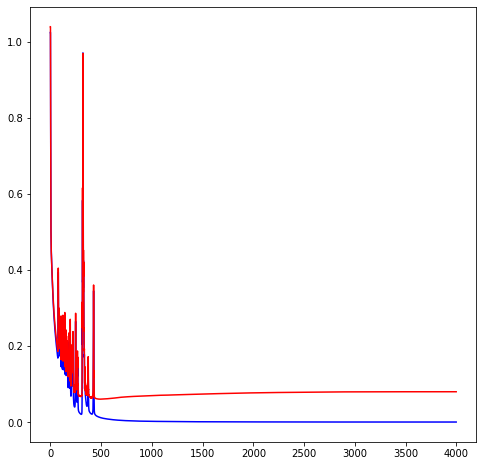

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(train_losses, label='Train', c='b')
plt.plot(test_losses, label='Test', c='r')
plt.show()

## 2. Plot the accuracy curve

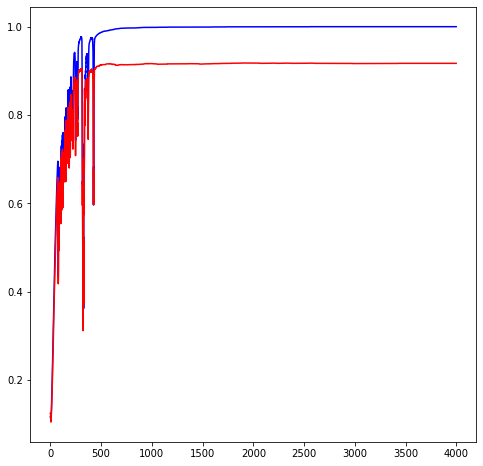

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(train_accuracyes, label='Train', c='b')
plt.plot(test_accuracyes, label='Test', c='r')
plt.show()

## 3. Plot the accuracy value

In [10]:
print(f'Final Train Accuracy: {train_accuracyes[-1] * 100}%')
print(f'Final Test Accuracy: {test_accuracyes[-1] * 100}%')

Final Train Accuracy: 100.0%
Final Test Accuracy: 91.7%


## 4. Plot the classification example

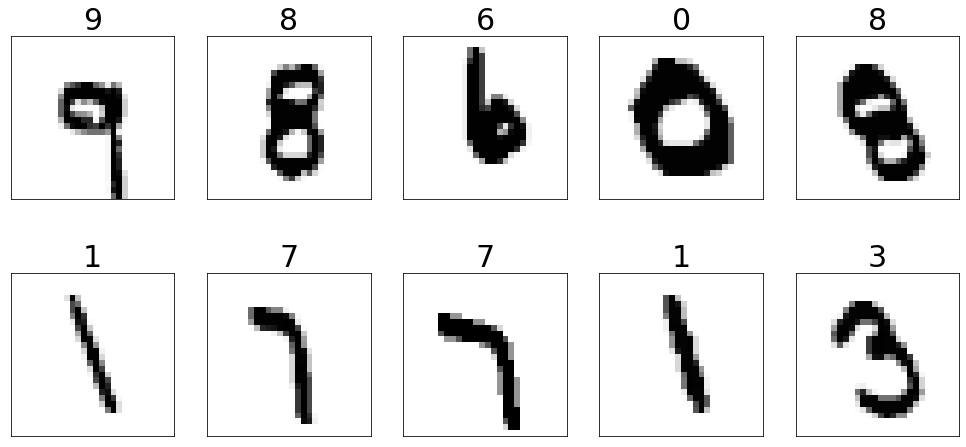

In [11]:
plt.figure(figsize=(17, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(correct_labels[i].get().argmax(), size=30)
    plt.imshow(correct_images[i].reshape(size_row, size_col).get(), cmap='Greys', interpolation='None')
    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    
plt.show()

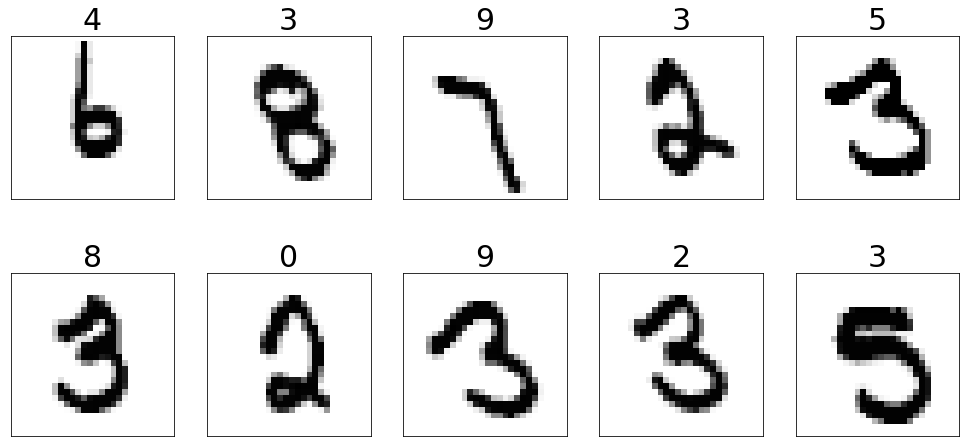

In [12]:
plt.figure(figsize=(17, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(worng_labels[i].get().argmax(), size=30)
    plt.imshow(worng_images[i].reshape(size_row, size_col).get(), cmap='Greys', interpolation='None')
    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    
plt.show()